In [1]:
using Revise
using Distributions
using SaferIntegers
using ProgressMeter
using DataFrames
using Plots

In [2]:
includet("SymmetricGames.jl")

In [3]:
full_pay_func = prof -> collect(1:1/(size(prof,1)-1):2) .* (prof .> 0)
dev_pay_func = prof-> collect(1:1/(size(prof,1)-1):2)

#3 (generic function with 1 method)

In [4]:
num_mixtures = 1000
max_points = Dict{Int64,Int64}()
for num_actions = 2:10
    for num_points = 2:1000
        if multinomial(num_actions-1, num_points) > num_mixtures
            max_points[num_actions] = num_points - 1
            break
        end
    end
end
max_points

Dict{Int64, Int64} with 9 entries:
  5  => 9
  4  => 16
  6  => 7
  7  => 6
  2  => 999
  10 => 4
  9  => 4
  8  => 5
  3  => 43

In [5]:
mixtures = Dict{Int64,Matrix{Float64}}()
for num_actions = 2:10
    mixtures[num_actions] = zeros(num_actions, num_mixtures)
    points_per_dim = max_points[num_actions]
    grid_size = multinomial(num_actions-1,points_per_dim)
    mixtures[num_actions][:,1:grid_size] = mixture_grid(num_actions, points_per_dim)
    if grid_size < num_mixtures
        mixtures[num_actions][:,grid_size+1:end] = random_mixtures(num_actions, num_mixtures - grid_size)
    end
end
mixtures

Dict{Int64, Matrix{Float64}} with 9 entries:
  5  => [1.0 0.888889 … 0.0304604 0.214983; 0.0 0.111111 … 0.0524869 0.241912; …
  4  => [1.0 0.9375 … 0.405652 0.13799; 0.0 0.0625 … 0.252988 0.205914; 0.0 0.0…
  6  => [1.0 0.857143 … 0.333282 0.0195612; 0.0 0.142857 … 0.0610934 0.296697; …
  7  => [1.0 0.833333 … 0.248734 0.0495848; 0.0 0.166667 … 0.206477 0.0967034; …
  2  => [1.0 0.998999 … 0.001001 0.0; 0.0 0.001001 … 0.998999 1.0]
  10 => [1.0 0.75 … 0.0995068 0.00791218; 0.0 0.25 … 0.22063 0.0702781; … ; 0.0…
  9  => [1.0 0.75 … 0.0770396 0.306937; 0.0 0.25 … 0.00572962 0.203806; … ; 0.0…
  8  => [1.0 0.8 … 0.0386295 0.292769; 0.0 0.2 … 0.0400795 0.050945; … ; 0.0 0.…
  3  => [1.0 0.976744 … 0.460517 0.456855; 0.0 0.0232558 … 0.495383 0.0388876; …

In [6]:
function tables_size(players, strategies, bits)
    return multinomial(players-1, strategies-1) * strategies * bits ÷ 4
end

tables_size (generic function with 1 method)

In [9]:
max_errors_32 = DataFrame(strategies=Int[], players=Int[], error=Float64[])
prog = Progress(9*999, 1)
for s in 2:10
    correct_payoffs = collect(1:1/(s-1):2)
    for p in 2:1000
        next!(prog)
        if tables_size(p,s,64) > 2^30
            for i in p+1:1000
                next!(prog)
            end
            break
        end
        g = GPUArrays(p,s,dev_pay_func)
        biggest_error = 0
        for m in 1:5:num_mixtures
            dev_pays = many_deviation_payoffs(g, mixtures[s][:,m:m+4])
            biggest_error = max(biggest_error, maximum(abs.(dev_pays .- correct_payoffs)))
        end
        push!(max_errors_32, (s, p, biggest_error))
    end
end
        

Progress: 100%|█████████████████████████████████████████| Time: 2:17:10


In [45]:
to_plot = zeros(9,999)
for s in 2:10
    for p in 2:1000
        selection = max_errors_32[max_errors_32.strategies .== s .&& max_errors_32.players .== p, :error]
        if length(selection) == 1
            to_plot[s-1,p-1] = selection[1]
        else
            to_plot[s-1,p-1] = NaN
        end
    end
end
size(to_plot)

(9, 999)

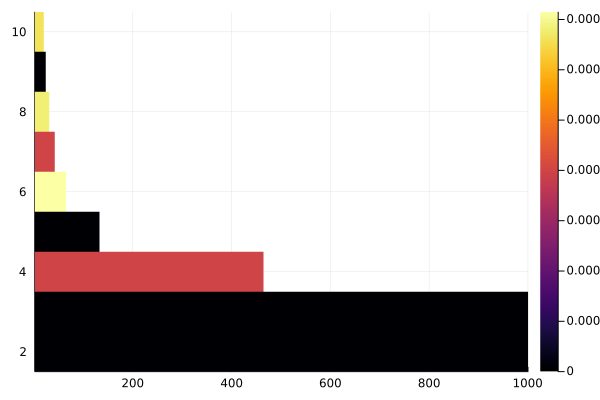

In [56]:
heatmap(2:1000, 2:10, to_plot)

In [55]:
for s in 2:10
    println("s = ", s, " min = ", minimum(filter(!isnan, to_plot[s-1,:])), " max = ", maximum(filter(!isnan, to_plot[s-1,:])))
end

s = 2 min = 0.0 max = 0.0
s = 3 min = 0.0 max = 0.0
s = 4 min = 3.9736429924275285e-8 max = 3.9736429924275285e-8
s = 5 min = 0.0 max = 0.0
s = 6 min = 7.152557368605983e-8 max = 7.152557368605983e-8
s = 7 min = 3.9736429924275285e-8 max = 3.9736429924275285e-8
s = 8 min = 6.811959396557654e-8 max = 6.811959396557654e-8
s = 9 min = 0.0 max = 0.0
s = 10 min = 6.622738313311061e-8 max = 6.622738313311061e-8
